In [1]:
import sys
import os

# Compute absolute path to the src/ folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add src/ to sys.path
sys.path.insert(0, src_path)

# Now you can import the code
from qvarnet.hamiltonians import GeneralHamiltonian, HarmonicOscillator
from qvarnet.models.mlp import MLP
from qvarnet.samplersv2 import MetropolisHastingsSampler


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.linalg import vector_norm

import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

def V(x):
    return 0.5 * x**2

In [61]:
epochs = 10000

Nh=10

model = MLP(layer_dims=[1, Nh, 1], activation="sigmoid")
model.to(device)

with torch.no_grad():
    for param in model.parameters():
        if param.dim() > 1:  # Only initialize weights, not biases
            nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

energies = []
losses = []
wavefunctions = []
x_sampled = []

L_BOX = 20.0

# x_train = torch.linspace(-L_BOX/2, L_BOX/2, 10000).view(-1, 1).to(device)
# x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=500, min_delta=1e-2)

print_interval = 10

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    x_train = torch.rand(10000, 1, device=device) * L_BOX - L_BOX / 2 # uniform sampling in the box
    x_train.requires_grad = True
    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    V_psi = V(x_train) * psi
    H_psi = T + V_psi

    numerator = torch.mean(psi * H_psi, dim=0)  # <psi|H|psi>
    # Compute the denominator <psi|psi>
    denominator = torch.mean(psi.pow(2), dim=0)  # <psi|psi>
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy
    energies.append(energy.item())
    
    
    losses.append(loss.item())
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}")
        wavefunctions.append(psi.detach().cpu().numpy())
        x_sampled.append(x_train.detach().cpu().numpy())
    

    if callback is not None:
        callback(epoch, loss, model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
print(energy)

Epoch 1/10000, Loss: 14.9627, Energy: 14.9627
Epoch 11/10000, Loss: 14.9061, Energy: 14.9061
Epoch 21/10000, Loss: 14.6221, Energy: 14.6221
Epoch 31/10000, Loss: 14.8021, Energy: 14.8021
Epoch 41/10000, Loss: 14.7585, Energy: 14.7585
Epoch 51/10000, Loss: 14.5540, Energy: 14.5540
Epoch 61/10000, Loss: 14.2737, Energy: 14.2737
Epoch 71/10000, Loss: 14.3718, Energy: 14.3718
Epoch 81/10000, Loss: 13.9887, Energy: 13.9887
Epoch 91/10000, Loss: 14.2688, Energy: 14.2688
Epoch 101/10000, Loss: 14.2110, Energy: 14.2110
Epoch 111/10000, Loss: 14.1120, Energy: 14.1120
Epoch 121/10000, Loss: 13.5740, Energy: 13.5740
Epoch 131/10000, Loss: 13.8202, Energy: 13.8202
Epoch 141/10000, Loss: 13.5515, Energy: 13.5515
Epoch 151/10000, Loss: 13.6662, Energy: 13.6662
Epoch 161/10000, Loss: 13.0505, Energy: 13.0505
Epoch 171/10000, Loss: 12.7935, Energy: 12.7935
Epoch 181/10000, Loss: 12.5580, Energy: 12.5580
Epoch 191/10000, Loss: 12.1229, Energy: 12.1229
Epoch 201/10000, Loss: 11.6599, Energy: 11.6599
Epo

Wavefunction history size: 343


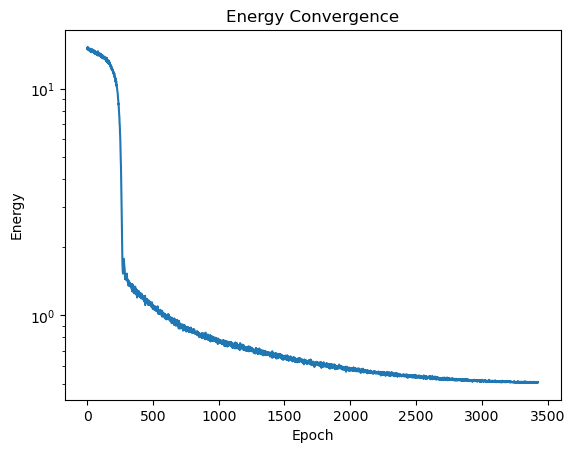

In [63]:
import numpy as np
import math

def exact_solution(x, n=0):
        coeff = np.sqrt(1 / (2**n * math.factorial(n))) * (1 / np.pi)**0.25
        return coeff * np.exp(-0.5*x**2)

def generate_anim(wave_function_history, xs, filename="wavefunction_animation.gif"):
    fig, ax = plt.subplots()
    print(f"Wavefunction history size: {len(wave_function_history)}")
    x_exact = np.linspace(-L_BOX/2, L_BOX/2, 1000)
    psi_exact = exact_solution(x_exact, n=0)  # Ground state wavefunction
    plt.plot(x_exact, psi_exact**2, label='Ground State Wavefunction', color='blue')
    
    line, = ax.plot(xs[0], wave_function_history[0]**2,'o' ,color="orange", markersize=1, label='Sampled Wavefunction')
    ax.set_ylim(-0.01, 0.8)
    ax.set_ylabel("ψ")
    ax.set_xlabel("x")
    def update(frame):
        line.set_xdata(xs[frame])
        norm = (L_BOX)*np.mean(wave_function_history[frame]**2)
        psi = wave_function_history[frame] / np.sqrt(norm)
        line.set_ydata(psi**2)
        ax.set_title(f"Epoch {frame*print_interval}")
        return line,
    plt.close(fig)  # Close the figure to prevent it from displaying immediately
    FFwriter = animation.FFMpegWriter(fps=10)

    ani = animation.FuncAnimation(fig, update, frames=len(wave_function_history), interval=50, blit=False)
    #save as video
    ani.save(filename, writer=FFwriter)#, fps=10)
    
    # ani.save(filename, writer='pillow', fps=10)

with torch.no_grad():
    generate_anim(wavefunctions, x_sampled, filename="uniform_sampling_wf_convergence.mp4")


plt.clf()
plt.plot(energies, label='Energy')
plt.xlabel('Epoch')
plt.ylabel('Energy')
plt.title('Energy Convergence')
plt.semilogy()
plt.show()